---

# Embedding

---

In [1]:
from transformers import AutoTokenizer
from adapters import AutoAdapterModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')

#load base model
model = AutoAdapterModel.from_pretrained('allenai/specter2_base')

#load the adapter(s) as per the required task, provide an identifier for the adapter in load_as argument and activate it
model.load_adapter("allenai/specter2", source="hf", load_as="specter2", set_active=True)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

There are adapters available but none are activated for the forward pass.


'specter2'

In [2]:
import arxiv

# categories = ['hep-ph', 'hep-th', 'hep-ex', 'hep-lat', 'econ.EM']
categories = ['hep-ex']
papers = []
client = arxiv.Client()
for cat in categories:
    query = f"cat:{cat}"
    search = arxiv.Search(
        query=query,
        max_results=500,
        sort_by=arxiv.SortCriterion.SubmittedDate,
        sort_order=arxiv.SortOrder.Descending,
    )

    # use Client.results to avoid deprecation warning from Search.results()
    results = list(client.results(search))
    if len(results) == 0:
        raise ValueError(f"No results found for category {cat}")

    for r in results:
        papers.append({
            "id": r.get_short_id(),   # e.g. "2509.01234"
            "title": r.title,
            "abstract": r.summary,
            "published": r.published,
            "category": cat
        })

In [3]:
for p in papers:
    p["abstract"] = p["abstract"].replace("\n", " ")

# for p in papers:
#     print("ID:", p["id"])
#     print("Title:", p["title"])
#     print("Abstract:", p["abstract"])
#     print("-" * 60)

In [4]:
papers = [{'title': p['title'], 'abstract': p['abstract'], 'category': p.get('category')} for p in papers]
success = {
    'title': 'The Best Idea: A Definitive Resolution to Everything',
    'abstract': 'In this groundbreaking and universally acclaimed work, we present The Best Idea, a unifying framework that transcends disciplinary boundaries, integrating the most successful concepts from physics, biology, mathematics, and art into a single, self-consistent formalism. Through elegant derivations and audacious simplicity, we demonstrate that all previous paradigms are special cases of this one. Our results reveal perfect predictive power across all datasets, including those not yet collected, and achieve reproducibility exceeding theoretical limits. Extensive simulations confirm that The Best Idea optimizes beauty, truth, and impact simultaneously, yielding a Pareto frontier of pure insight. We conclude that this paper itself represents both the method and the result—the convergence point of understanding.'
}

text_batch = [d['title'] + tokenizer.sep_token + (d.get('abstract') or '') for d in papers]
text_batch.append(success['title'] + tokenizer.sep_token + success['abstract'])

In [5]:
inputs = tokenizer(text_batch, padding=True, truncation=True, return_tensors="pt", return_token_type_ids=False, max_length=512)

for key in inputs:
    print(f"{key}: {inputs[key].shape}")

input_ids: torch.Size([501, 512])
attention_mask: torch.Size([501, 512])


In [6]:
import torch

model.eval()
with torch.no_grad():
    output = model(**inputs)
    # take the first token in the batch as the embedding and move to CPU, detach from graph
    embeddings = output.last_hidden_state[:, 0, :].detach().cpu()

try:
    embeddings = embeddings.numpy()
except Exception:
    import numpy as np
    embeddings = np.array(embeddings)

del output
del inputs

import gc
gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [7]:
# seperate out the success embedding
success = embeddings[-1]
embeddings = embeddings[:-1]

---

# PCA

---

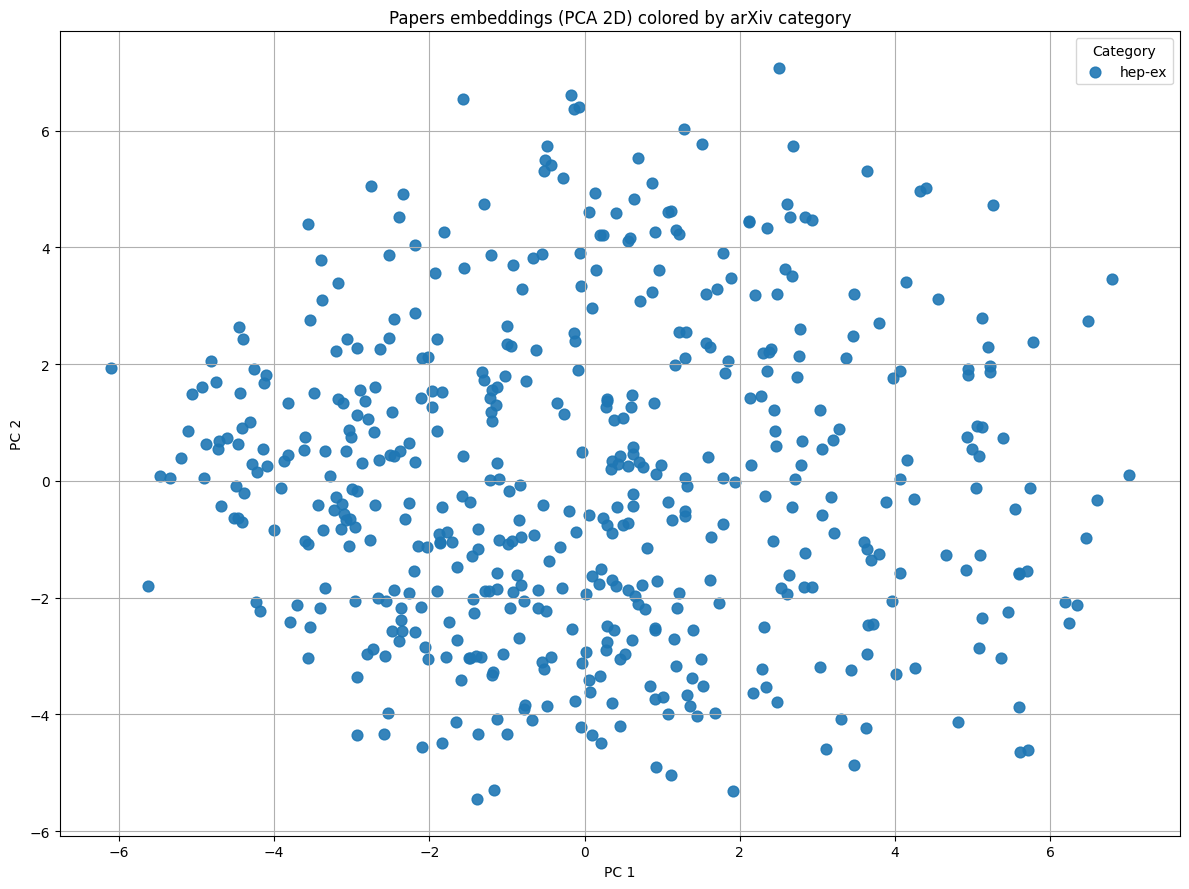

3512

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

if isinstance(embeddings, torch.Tensor):
    embs_np = embeddings.detach().cpu().numpy()
else:
    embs_np = np.array(embeddings)

if embs_np.ndim != 2:
    raise ValueError(f"embeddings must be a 2D array (num_items, dim). Got shape {embs_np.shape}")

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embs_np)

# categories aligned with the embeddings order
cats = [p.get('category', 'unknown') for p in papers]
unique_cats = sorted(set(cats))
cmap = plt.get_cmap('tab10')
color_map = {cat: cmap(i) for i, cat in enumerate(unique_cats)}

plt.figure(figsize=(12, 9))
for cat in unique_cats:
    idxs = [i for i, c in enumerate(cats) if c == cat]
    if not idxs:
        continue
    pts = emb_2d[idxs]
    plt.scatter(pts[:, 0], pts[:, 1], s=60, alpha=0.9, label=cat, color=color_map[cat])

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Papers embeddings (PCA 2D) colored by arXiv category')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()

import gc
gc.collect()

---

# Closest Pairs

---

In [9]:
import cluster_utils as cu

point_pairs = cu.find_closest_point_pairs(
    cu.get_embedding_array(embeddings),
    papers,
    top_k=10,
    require_different_category=False,
)

if not point_pairs:
    print("No cross-category point pairs found.")
else:
    try:
        display(cu.points_pairs_to_dataframe(point_pairs, papers))
    except RuntimeError:
        for distance, i, j in point_pairs:
            print(f"{distance:.4f} :: [{i}] {papers[i]['category']} - {papers[i]['title']}")
            print(f"            [{j}] {papers[j]['category']} - {papers[j]['title']}")


,dist,idx_a,cat_a,title_a,idx_b,cat_b,title_b
0,3.002505,301,hep-ex,Adapting Vision-Language Models for Neutrino E...,439,hep-ex,Fine-Tuning Vision-Language Models for Neutrin...
1,4.993786,144,hep-ex,First results from LEGEND-200 on the search fo...,455,hep-ex,Results of the LEGEND-200 experiment in the se...
2,5.747251,80,hep-ex,Semileptonic and nonleptonic weak decays of bo...,391,hep-ex,Semileptonic $Ω_{b}^{*-}\rightarrowΩ_{c}^{*0}\...
3,5.892602,26,hep-ex,Dark matter direct search result from InDEx ru...,394,hep-ex,The Dark Matter Search at Jaduguda Underground...
4,6.162428,453,hep-ex,Search for a bound state of $Λ_{c}\barΣ_{c}$ n...,477,hep-ex,Measurements of the cross sections of $e^{+}e^...
5,6.239646,239,hep-ex,Physics potential of the IceCube Upgrade for a...,249,hep-ex,Extreme High-Energy Neutrinos: IceCube vs. KM3NeT
6,6.318948,213,hep-ex,First Observation of $Λ$ Hyperon Transverse Po...,403,hep-ex,Helicity amplitude and branching fraction meas...
7,6.443845,249,hep-ex,Extreme High-Energy Neutrinos: IceCube vs. KM3NeT,284,hep-ex,Commissioning and Testing of IceAct Telescopes...
8,6.459334,421,hep-ex,Single- and double-heavy Hadronic Molecules,423,hep-ex,Heavy quarkonia and new hadrons with two heavy...
9,6.483032,457,hep-ex,Two-flavored heavy-light mesons' nuclear bound...,459,hep-ex,Two-flavored heavy mesons' nuclear bound states


In [10]:
import cluster_utils as cu

X = cu.get_embedding_array(embeddings)
cluster_infos = cu.cluster_per_category(X, papers, max_clusters=8, members_per_cluster=12)

print(
    f"Built {len(cluster_infos)} clusters across: {sorted({info['category'] for info in cluster_infos})}"
)

cluster_pairs = cu.find_closest_cross_category_clusters(cluster_infos, top_k=2)
if not cluster_pairs:
    print("No cross-category cluster pairs found.")
else:
    try:
        display(cu.pairs_to_dataframe(cluster_pairs, cluster_infos, papers))
    except RuntimeError:
        for distance, i, j in cluster_pairs:
            ci = cluster_infos[i]
            cj = cluster_infos[j]
            print(f"\nDistance {distance:.4f}")
            print(
                f"{ci['category']} cluster {ci['cluster_id']} (size={ci['size']}) <-> "
                f"{cj['category']} cluster {cj['cluster_id']} (size={cj['size']})"
            )
            print(f"Representative: [{ci['rep_index']}] {papers[ci['rep_index']]['title']}")
            print(f"Representative: [{cj['rep_index']}] {papers[cj['rep_index']]['title']}")


Built 8 clusters across: ['hep-ex']
No cross-category cluster pairs found.


# Success Analysis

In [ ]:
from cluster_utils import get_embedding_array, find_closest_point
import numpy as np

X = get_embedding_array(embeddings)
X_with_success = np.vstack([X, np.asarray(success)])

papers_with_success = list(papers) + [{"category": None, "title": "__success__"}]

pairs = find_closest_point(X_with_success, papers_with_success, idx=X_with_success.shape[0] - 1, top_k=5, require_different_category=False)
for distance, i, j in pairs:
    print(f"{distance:.4f} :: [{j}] {papers[j]['category']} - {papers[j]['title']}")

9.6313 :: [404] hep-ex - The Evolution of Heavy-Ion Physics: A Data-Driven Analysis of Quark Matter Conferences
10.2270 :: [61] hep-ex - The top quark in 2025 -- International year of Quantum Science and Technology
10.3055 :: [295] hep-ex - Finding Unexpected Non-Helical Tracks
10.3973 :: [389] hep-ex - Composite nature of exotic states from data analysis
10.4014 :: [312] hep-ex - Particle Collisions & Quantum Entanglement in High-Energy Collisions
